In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
import seaborn as sns

# files

In [2]:
PREFIX = "AGARWAL.seqs"

AGARWAL_PATH ="/wynton/home/ahituv/fongsl/MPRA/agarwal_2023"
TRUTH = os.path.join(AGARWAL_PATH, "all_cell_types_summary.csv")  # US activity in HepG2

PATH = "/wynton/home/ahituv/fongsl/EMF/US/data"
INPUT_DATA = os.path.join(PATH, f"{PREFIX}.txt") # US library
MODEL = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/model_300.pth"
PRED_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/"
PRED = os.path.join(PRED_PATH, f"inference.{PREFIX}.tsv")  # legnet predictions
PRED_IN = os.path.join(PATH, f"{PREFIX}.all.tsv")  # seq.id + seq
PRED_COOR = os.path.join(AGARWAL_PATH, f"joint_library.bed")  # seq.id + seq

FAKE_TRAIN = os.path.join(PATH, "AGARWAL_RAND5K_WTC11.txt")  # fake training data
FAKE_TEST = os.path.join(PATH, "AGARWAL_RAND5K_WTC11_test.txt")  # fake training data

SEQ_SIZE = 200

# run legnet

In [3]:
def launchLegNet(input_file, seqsize, model):
    """ predict 18 bins using input sequence, write to output file, specify sequence size"""

    PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/bin/"
    LEGNET_SH = os.path.join(PATH, "legnet_inference.sh")

    OUTPUT_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/"

    # str split to make output file a copy of the input file.
    infile = os.path.split(input_file)[1]
    outfile = os.path.join(OUTPUT_PATH, "inference." + ".".join(infile.split(".")[:-1]) + ".tsv")

    cmd = " ".join(["qsub -q gpu.q",
                   LEGNET_SH,
                   input_file,
                   outfile,
                   str(seqsize),
                    model
                   ])
    #print(cmd)
    #os.system(cmd)
    if os.path.exists(outfile) is False:
        print("running...")
        os.system(cmd)
    else:
        print("skipping...", outfile)

## cmd

In [4]:
launchLegNet(INPUT_DATA, SEQ_SIZE, MODEL)

skipping... /wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/inference.AGARWAL.seqs.tsv


# Truth v. Pred

In [5]:
# load truth
MEASURE = "mean"  # med

truth = pd.read_csv(TRUTH) # load data

#truth["ctrl"] = truth["name"].apply(lambda x: True if "neg" in x else False)  # make column for synthetic sequence
truth.head()

,name,HepG2 [log2(rna/dna)],K562 [log2(rna/dna)],WTC11 [log2(rna/dna)]
0,WTC11_seq9998_F,-1.018,-1.018,-1.254
1,WTC11_seq9987_F,0.320,-0.439,-1.505
2,WTC11_seq998_F,0.003,-0.217,-0.462
3,WTC11_seq9970_F,-0.794,-1.026,-1.414
4,WTC11_seq9967_F,-0.485,-0.592,-1.346


In [6]:
# load predictions
pred = pd.read_csv(PRED, sep='\t', header=None, names=["seq", "pred"])
pred.head()

,seq,pred
0,GTAGGACCAGGCTCTGCCTCCTTCTCTCTCCCCCGACCCACCTGCC...,7.946445
1,TGTACTTGCCTTAGGAGGTCAAACACATTAGGTATACCAACATATC...,3.422889
2,TAGCTCAACACAAATCCATCACTGAAAGCAGTGCAACCAAGGCAGC...,3.789355
3,GACCCTAAATCAGTATGGGGAAAGGTCCCCACTGCAGCACTTTCTA...,4.969305
4,GTGATCTCAGCTTACTGCAACCTCTGCCTCCTGGGTTCAAGCAATT...,7.915025


In [7]:
# load bedfile
bed = pd.read_csv(PRED_COOR, sep='\t')
bed["seq.id"] = bed["#chr"] + ":"+ bed["start.hg38"].map(str) + "-" + bed["stop.hg38"].map(str)
bed.head()

,#chr,start.hg38,stop.hg38,name,str.hg38,seq.id
0,chr1,19461350,19461550,WTC11_seq1000_F,+,chr1:19461350-19461550
1,chr10,88965538,88965738,WTC11_seq10002_F,+,chr10:88965538-88965738
2,chr10,89029900,89030100,WTC11_seq10004_F,+,chr10:89029900-89030100
3,chr10,89032143,89032343,WTC11_seq10005_F,+,chr10:89032143-89032343
4,chr10,89111910,89112110,WTC11_seq10007_F,+,chr10:89111910-89112110


In [8]:
# load seq_id
seq_id = pd.read_csv(PRED_IN, sep='\t', names=["seq.id", "seq"])
seq_id.head()

,seq.id,seq
0,chr1:19461350-19461550,GTAGGACCAGGCTCTGCCTCCTTCTCTCTCCCCCGACCCACCTGCC...
1,chr10:88965538-88965738,TGTACTTGCCTTAGGAGGTCAAACACATTAGGTATACCAACATATC...
2,chr10:89029900-89030100,TAGCTCAACACAAATCCATCACTGAAAGCAGTGCAACCAAGGCAGC...
3,chr10:89032143-89032343,GACCCTAAATCAGTATGGGGAAAGGTCCCCACTGCAGCACTTTCTA...
4,chr10:89111910-89112110,GTGATCTCAGCTTACTGCAACCTCTGCCTCCTGGGTTCAAGCAATT...


## merge seq_id, pred, bed, truth

In [9]:
# merge prediction with sequence id
pred = pd.merge(seq_id, pred)
pred = pd.merge(pred, bed[['seq.id', "name"]])

# merge truth and prediction
merged = pd.merge(pred, truth)
merged.head()

,seq.id,seq,pred,name,HepG2 [log2(rna/dna)],K562 [log2(rna/dna)],WTC11 [log2(rna/dna)]
0,chr1:19461350-19461550,GTAGGACCAGGCTCTGCCTCCTTCTCTCTCCCCCGACCCACCTGCC...,7.946445,WTC11_seq1000_F,0.633,0.080,-0.387
1,chr10:88965538-88965738,TGTACTTGCCTTAGGAGGTCAAACACATTAGGTATACCAACATATC...,3.422889,WTC11_seq10002_F,-1.157,-1.147,-1.507
2,chr10:89029900-89030100,TAGCTCAACACAAATCCATCACTGAAAGCAGTGCAACCAAGGCAGC...,3.789355,WTC11_seq10004_F,-0.066,0.186,0.655
3,chr10:89032143-89032343,GACCCTAAATCAGTATGGGGAAAGGTCCCCACTGCAGCACTTTCTA...,4.969305,WTC11_seq10005_F,0.846,1.212,-0.637
4,chr10:89111910-89112110,GTGATCTCAGCTTACTGCAACCTCTGCCTCCTGGGTTCAAGCAATT...,7.915025,WTC11_seq10007_F,-0.784,-0.630,-0.612


### WTC11 MPRA activity split into quantiles

In [10]:
## rank WTC11 activity into 18 bins

# split into 18 groups
merged['WTC11_q'] = pd.qcut(merged['WTC11 [log2(rna/dna)]'], 18, labels=np.arange(18))
merged['WTC11_q'] = merged['WTC11_q'].astype(float)

merged.head()

,seq.id,seq,pred,name,HepG2 [log2(rna/dna)],K562 [log2(rna/dna)],WTC11 [log2(rna/dna)],WTC11_q
0,chr1:19461350-19461550,GTAGGACCAGGCTCTGCCTCCTTCTCTCTCCCCCGACCCACCTGCC...,7.946445,WTC11_seq1000_F,0.633,0.080,-0.387,12.0
1,chr10:88965538-88965738,TGTACTTGCCTTAGGAGGTCAAACACATTAGGTATACCAACATATC...,3.422889,WTC11_seq10002_F,-1.157,-1.147,-1.507,2.0
2,chr10:89029900-89030100,TAGCTCAACACAAATCCATCACTGAAAGCAGTGCAACCAAGGCAGC...,3.789355,WTC11_seq10004_F,-0.066,0.186,0.655,15.0
3,chr10:89032143-89032343,GACCCTAAATCAGTATGGGGAAAGGTCCCCACTGCAGCACTTTCTA...,4.969305,WTC11_seq10005_F,0.846,1.212,-0.637,10.0
4,chr10:89111910-89112110,GTGATCTCAGCTTACTGCAACCTCTGCCTCCTGGGTTCAAGCAATT...,7.915025,WTC11_seq10007_F,-0.784,-0.630,-0.612,10.0


In [11]:
bed.shape, pred.shape, merged.shape, 

((59330, 6), (59330, 4), (56345, 8))

## WTC11 MPRA

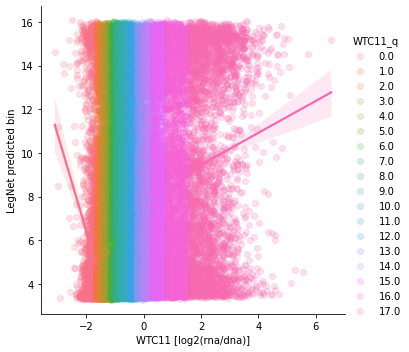

In [14]:
x="WTC11 [log2(rna/dna)]"
y="pred"
g=sns.lmplot(x=x, y=y, data=merged, 
           hue="WTC11_q", 
          scatter_kws={"alpha":0.2})
g.set(ylabel="LegNet predicted bin")

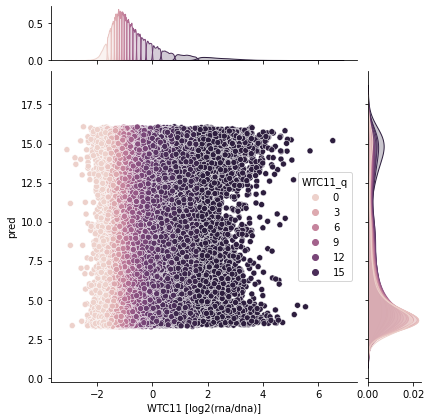

In [16]:
x="WTC11 [log2(rna/dna)]"
y="pred"
g=sns.jointplot(x=x, y=y, data=merged, 
           hue="WTC11_q", 
          #scatter_kws={"alpha":0.2},
              marginal_ticks=True
             )


## fill na w/ zeros

In [17]:
test = merged.fillna(0)

In [18]:
# pearson, spearman
stats.pearsonr(test[x], test[y]), stats.spearmanr(test[x], test[y])

((0.31932732612936476, 0.0),
 SpearmanrResult(correlation=0.3286960134266719, pvalue=0.0))

WTC11


    ((0.316254248136727, 0.0),
     SpearmanrResult(correlation=0.32341219943458566, pvalue=0.0))

## HepG2 MPRA

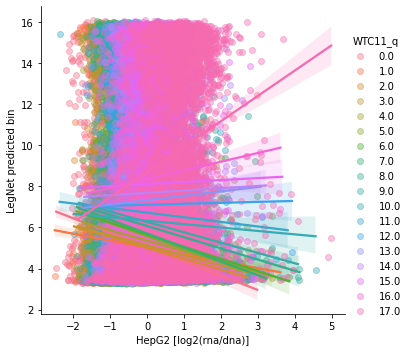

In [19]:
x="HepG2 [log2(rna/dna)]"
y="pred"
g = sns.lmplot(x=x, y=y, data=merged, 
           hue="WTC11_q", 
          scatter_kws={"alpha":0.4}, 
         )
g.set(ylabel="LegNet predicted bin")

In [20]:
# pearson, spearman
stats.pearsonr(merged[x], merged[y]), stats.spearmanr(merged[x], merged[y])

((0.1262417202894474, 7.41140891995903e-199),
 SpearmanrResult(correlation=0.15902788559769152, pvalue=0.0))

HepG2:
        
    ((0.12551376346319143, 1.414916369293078e-196),
     SpearmanrResult(correlation=0.15845689586256376, pvalue=0.0))

## k562 MPRA

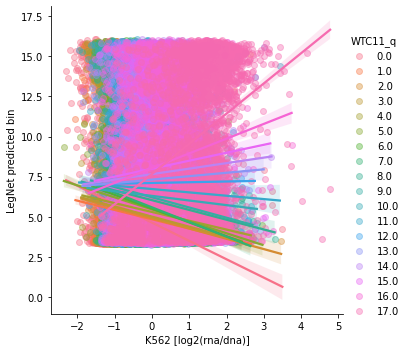

In [21]:
x="K562 [log2(rna/dna)]"
y="pred"
g = sns.lmplot(x=x, y=y, data=merged, 
           hue="WTC11_q", 
          scatter_kws={"alpha":0.4})
g.set(ylabel="LegNet predicted bin")

In [22]:
# pearson, spearman
stats.pearsonr(test[x], test[y]), stats.spearmanr(test[x], test[y])

((0.18559277976027275, 0.0),
 SpearmanrResult(correlation=0.17850955064615215, pvalue=0.0))

k562:
        
        ((0.18226562465561197, 0.0),
     SpearmanrResult(correlation=0.17494234006248102, pvalue=0.0))

# make fake training data

# write fake training data to file

In [23]:
merged[['seq',"WTC11 [log2(rna/dna)]", 'WTC11_q']].head()

,seq,WTC11 [log2(rna/dna)],WTC11_q
0,GTAGGACCAGGCTCTGCCTCCTTCTCTCTCCCCCGACCCACCTGCC...,-0.387,12.0
1,TGTACTTGCCTTAGGAGGTCAAACACATTAGGTATACCAACATATC...,-1.507,2.0
2,TAGCTCAACACAAATCCATCACTGAAAGCAGTGCAACCAAGGCAGC...,0.655,15.0
3,GACCCTAAATCAGTATGGGGAAAGGTCCCCACTGCAGCACTTTCTA...,-0.637,10.0
4,GTGATCTCAGCTTACTGCAACCTCTGCCTCCTGGGTTCAAGCAATT...,-0.612,10.0


In [24]:
from sklearn.metrics import mean_squared_error

test = merged.loc[~merged["WTC11_q"].isna()]
mean_squared_error(test["WTC11_q"].fillna(0), test["pred"])#.fillna(0))

32.98327495191707

<AxesSubplot:xlabel='WTC11_q', ylabel='pred'>

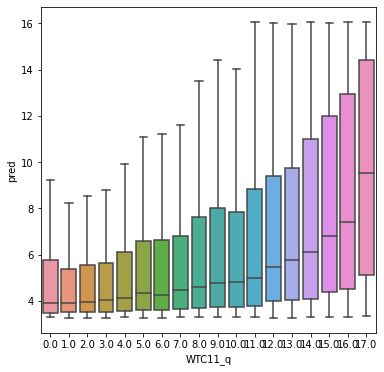

In [25]:
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(x="WTC11_q", y = "pred", data=merged, showfliers=False)

## write fake train data

In [32]:
if os.path.exists(FAKE_TRAIN) is False:
    fake=merged[['seq','WTC11_q']].sample(frac=0.9)
    fake.to_csv(FAKE_TRAIN, sep='\t', header=None, index=False)
    print("randomly sampled sequences")

else:
    print(FAKE_TRAIN)

    fake = pd.read_csv(FAKE_TRAIN, sep='\t', header=None, names=["seq", "WTC11_q"])
print(fake.shape)
fake.head()

/wynton/home/ahituv/fongsl/EMF/US/data/AGARWAL_RAND5K_WTC11.txt
(50710, 2)


,seq,WTC11_q
0,TCTTCTGGGAGGGGCTGGAGGGTTCCATTGTCTGGTCTCCTGCGTC...,14.0
1,TGCCCCTCTCAACTGATGGAAAGGGACCTTGACAGGCTAGATAAGC...,11.0
2,GGCGGGGGATTTACAGCCTCCCCCACCGTGGGGCTACCAAGCCTGT...,11.0
3,GCGACAGGACGGCACTGGGGAGGGACCATTGGTCCAGTTCCTGCAG...,8.0
4,TCCGGAGGTTGGTGCCCAGAGCCTAGCCCCAGGCTCATGCAAATTC...,17.0


## subtract fake training from total data

In [33]:
fake_test = merged.loc[~merged["seq"].isin(fake["seq"].unique())]

fake.shape, fake_test.shape, merged.shape

((50710, 2), (5635, 8), (56345, 8))

## write fake test

In [34]:
fake_test[['seq','WTC11_q']].drop_duplicates().to_csv(FAKE_TEST, sep='\t', index=False, header=False)

# interpretations
- WTC11 looks the best. Pearson's R= 0.32, Spearman = 0.32

- HepG2 is the worst. Pearson's R = 0.12, Spearman (robust) = 0.15

- k562 is intermediate. Pearson's R = 0.18, Spearman = 0.17